<img src="images/logos/esgf2-us.png" width=250 alt="ESGF logo"></img>

# Introduction to `intake-esgf`

## Overview
In this tutorial we will discuss the basic functionality of [intake-esgf](https://github.com/esgf2-us/intake-esgf) and describe some of what it is doing under the hood. `intake-esgf` is an `intake` and `intake-esm` *inspired* package under development in ESGF2. Please note that there is a name collison with an existing package in PyPI and conda. You will need to install the package from [source](https://github.com/esgf2-us/intake-esgf). 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Install Package](https://github.com/esgf2-us/intake-esgf) | Necessary | `pip install git+https://github.com/esgf2-us/intake-esgf`|
| Familiar with [intake-esm](https://intake-esm.readthedocs.io/en/stable/) | Helpful | Similar interface |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
- **Time to learn**: 30 minutes

## Imports

In [1]:
from intake_esgf import ESGFCatalog
import matplotlib.pyplot as plt

## Populate the Catalog

Unlike `intake-esm`, our catalogs initialize empty. This is because while `intake-esm`
loads a large file-based database into memory, we are going to populate a catalog by
searching one or many index nodes. The `ESGFCatalog` is configured by default to query
a Globus (ElasticSearch) based index which has information about holdings at the (Argonne Leadership Computing Facility (ALCF) only. We will demonstrate how this may be expanded to include other nodes later.

In [2]:
cat = ESGFCatalog(esgf1_indices="esgf-node.llnl.gov")
print(cat)  # <-- nothing to see here yet

Perform a search() to populate the catalog.


In [3]:
cat.search(
    experiment_id="historical",
    source_id="CanESM5",
    frequency="mon",
    variable_id=["gpp", "tas", "pr"],
)
print(cat)

   Searching indices:   0%|          |0/2 [       ?index/s]

   Searching indices: 100%|██████████|2/2 [    1.02s/index]


Summary information for 195 results:
mip_era                                                     [CMIP6]
activity_id                                                  [CMIP]
institution_id                                              [CCCma]
source_id                                                 [CanESM5]
experiment_id                                          [historical]
member_id         [r28i1p2f1, r6i1p2f1, r14i1p1f1, r20i1p2f1, r2...
table_id                                               [Lmon, Amon]
variable_id                                          [gpp, tas, pr]
grid_label                                                     [gn]
dtype: object


The search has populated the catalog where results are stored internally as a `pandas` dataframe, where the columns are the facets common to ESGF. Printing the catalog will display each column as well as a possibly-truncated list of unique values. We can use these to help narrow down our search. In this case, we neglected to mention a `member_id` (also known as a `variant_label`). So we can repeat our search with this additional facet. Note that searches are not cumulative and so we need to repeat the previous facets in this subsequent search. Also, while for the tutorial's sake we repeat the search here, in your own analysis codes, you could simply edit your previous search.

In [4]:
cat.search(
    experiment_id="historical",
    source_id="CanESM5",
    frequency="mon",
    variable_id=["gpp", "tas", "pr"],
    variant_label="r1i1p1f1",  # addition from the last search
)
print(cat)

   Searching indices: 100%|██████████|2/2 [    2.01index/s]

Summary information for 3 results:
mip_era                  [CMIP6]
activity_id               [CMIP]
institution_id           [CCCma]
source_id              [CanESM5]
experiment_id       [historical]
member_id             [r1i1p1f1]
table_id            [Lmon, Amon]
variable_id       [gpp, tas, pr]
grid_label                  [gn]
dtype: object


## Obtaining the datasets

Now we see that our search has located 3 datasets and thus we are ready to load these into memory. Like `intake-esm`, the catalog will generate a dictionary of `xarray` datasets. Internally, the catalog is again communicating with the index node and requesting file information. This includes which file or files are part of the datasets, their local paths, download locations, and verification information. We then try to make an optimal decision in getting the data to you as quickly as we can.

1. If you are running on a resource with direct access to the ESGF holdings (such a Jupyter notebook on nimbus.llnl.gov), then we check if the dataset files are locally available. We have a handful of locations built-in to `intake-esgf` but you can also set a location manually with `cat.set_esgf_data_root()`.
2. If a dataset has associated files that have been previously downloaded into the local cache, then we will load these files into memory.
3. If no direct file access is found, then we will queue the dataset files for download. File downloads will occur in parallel from the locations which provide you the fastest transfer speeds. Initially we will randomize the download locations, but as you use `intake-esgf`, we keep track of which servers provide you fastest transfer speeds and future downloads will prefer these locations. Once downloaded, we check file validity, and load into `xarray` containers.

In [5]:
dsd = cat.to_dataset_dict()

Adding cell measures: 100%|██████████|3/3 [  4.15s/dataset]


You will notice that progress bars inform you that file information is being obtained
and that downloads are taking place. As files are downloaded, they are placed into a
local cache in `${HOME}/.esgf` in a directory structure that mirrors that of the
remote storage. For future analysis which uses these datasets, `intake-esgf` will
first check this cache to see if a file already exists and use it instead of
re-downloading. Then it returns a dictionary whose keys are by default the minimal set
of facets to uniquely describe a dataset in the current search.

In [6]:
print(dsd.keys())

dict_keys(['Amon.tas', 'Amon.pr', 'Lmon.gpp'])


During the download process, you may have also noticed that a progress bar informed
you that we were adding cell measures. If you have worked with ESGF data before, you
know that cell measure information like `areacella` is needed to take proper
area-weighted means/summations. Yet many times, model centers have not uploaded this
information uniformly in all submissions. We perform a search for each dataset being
placed in the dataset dictionary, progressively dropping dataset facets to find, if
possible, the cell measures that are *closest* to the dataset being downloaded.
Sometimes they are simply in another `variant_label`, but other times they could be in a
different `activity_id`. No matter where they are, we find them for you and add them
by default (disable with `to_dataset_dict(add_measures=False)`). 

We determine which measures need downloaded by looking in the dataset attributes. Since `tas` is an atmospheric variable, we will see that its `cell_measures = 'area: areacella'`. If you print this variable you will see that measure has been added.

In [7]:
dsd["Amon.tas"]

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/872062df-acae-499b-aa0f-9eaca76...
    variable_id:                 tas
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

However, for `gpp` we also need the land fractions, which is detected by the presence of `area: where land` in the `cell_methods`. You will notice that both `areacella` and `sftlf` are added to `Lmon.gpp`.

In [8]:
dsd["Lmon.gpp"]

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    type       |S4 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    gpp        (time, lat, lon) float32 ...
    areacella  (lat, lon) float32 ...
    sftlf      (lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/387658c8-f085-4ab8-995c-def848e...
    variable_id:                 gpp
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

## Simple Plotting

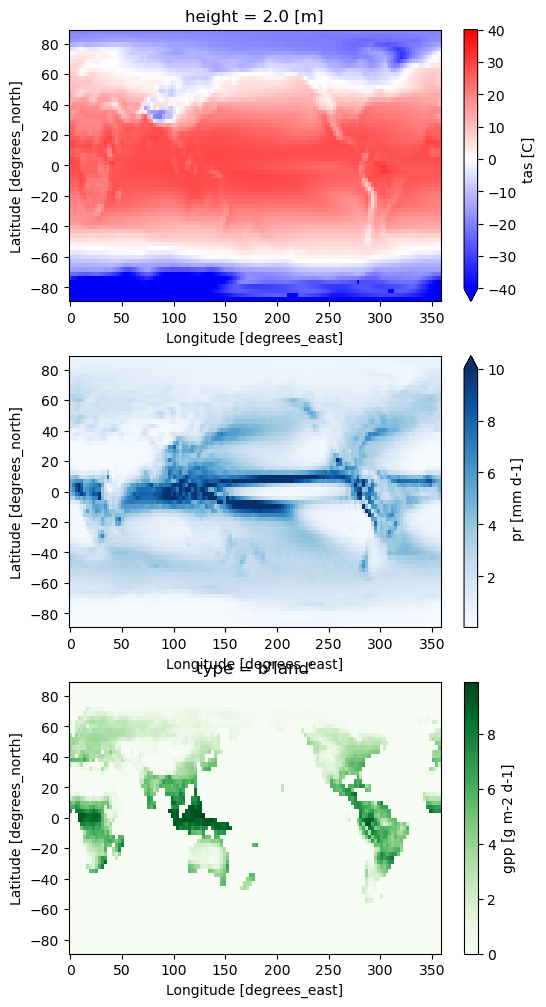

In [9]:
fig, axs = plt.subplots(figsize=(6, 12), nrows=3)

# temperature
ds = dsd["Amon.tas"]["tas"].mean(dim="time") - 273.15  # to [C]
ds.plot(ax=axs[0], cmap="bwr", vmin=-40, vmax=40, cbar_kwargs={"label": "tas [C]"})

# precipitation
ds = dsd["Amon.pr"]["pr"].mean(dim="time") * 86400 / 999.8 * 1000  # to [mm d-1]
ds.plot(ax=axs[1], cmap="Blues", vmax=10, cbar_kwargs={"label": "pr [mm d-1]"})

# gross primary productivty
ds = dsd["Lmon.gpp"]["gpp"].mean(dim="time") * 86400 * 1000  # to [g m-2 d-1]
ds.plot(ax=axs[2], cmap="Greens", cbar_kwargs={"label": "gpp [g m-2 d-1]"});

## Summary

`intake-esgf` becomes the way that you download or locate data as well as load it into memory. It is a full specification of what your analysis is about and makes your script portable to other machines or even in use with serverside computing. We are actively developing this codebase. Let us [know](https://github.com/esgf2-us/intake-esgf/issues) what other features you would like to see.